##### Data Manipulation
1- Feature Engineering:
 * group relevant features.  

2- Responses: 
    
   * select responses within reseasonable ranges (number of skills).

3- Classes: 
    
 * drop irrelevant classes.
 * merge close classes.
 * split vague classes.

In [1]:
ENCODED_DF = '../data/processed/encoded_df.pkl'
CLUSTER_SKILLS_DF_PATH='../data/processed/clustered_skills_df.pkl'
CLEANED_DF_PATH = '../data/processed/cleaned_df.pkl'
EXCLUDE_ROLES = ['Developer Advocate','Developer Experience',
'Product manager','Project manager' ,'Engineering manager',
'Senior Executive (C-Suite, VP, etc.)','Educator']



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score



In [3]:
df = pd.read_pickle(ENCODED_DF)
df.sample(1)

LanguageHaveWorkedWith                                                  \
                         APL Ada Apex Assembly Bash/Shell (all shells)  C C#   
80450                      0   0    0        0                       0  0  0   

                         ...                    DevType                      \
      C++ Clojure Cobol  ... Engineer, site reliability Engineering manager   
80450   0       0     0  ...                        0.0                 0.0   

                                                         \
      Hardware Engineer Product manager Project manager   
80450               0.0             0.0             0.0   

                                                                   \
      Research & Development role Scientist Security professional   
80450                         0.0       0.0                   0.0   

                                                                 
      Senior Executive (C-Suite, VP, etc.) System administrator  
80450                                  0.0                  0.0  

[1 rows x 298 columns]

In [4]:
def display_first_column(df):
    print(set([col1 for col1,col2 in df.columns]))

# 1-Feature Engineering

In [5]:
# extracting features from the dataframe , and applying standard scaling
df_skills = df.drop(columns = ['DevType']).copy()
std_skills = StandardScaler().fit_transform(df_skills)


### Applying dimensionality

Trying both linear and non-linear dimensionality reduction methods

In [39]:
def apply_dimensionality_reduction(projection_method):
    # apply dimensionality reduction
    projection = projection_method.fit_transform(std_skills.T)

    projection_df = pd.DataFrame(projection, index=[skill for skill_group, skill in df_skills.columns])
    
    fig = px.scatter(projection_df, x=0, y=1)
    # display points names
    for i, txt in enumerate(projection_df.index):
        fig.add_annotation(x=projection_df.iloc[i,0], y=projection_df.iloc[i,1], text=txt, showarrow=False)
    fig.update_layout(title=f'{projection_method} of skills')
    fig.update_traces(marker=dict(size=12,
                                line=dict(width=2,
                                            color='DarkSlateGrey')),
                    selector=dict(mode='markers'))
    # resize plot
    fig.update_layout( width=1000,
                    height=1000)
    fig.show()
    return projection_df

In [40]:
# apply dimensionality reduction using pca with linear kernel
apply_dimensionality_reduction(KernelPCA(n_components=2, kernel='linear'))


,0,1
APL,7.969602,-31.557341
Ada,10.144075,-31.684015
Apex,11.605726,-12.059981
Assembly,7.180063,-58.986412
Bash/Shell (all shells),-48.702339,-25.984229
...,...,...
Visual Studio,189.014866,0.571905
Visual Studio Code,27.423609,58.534175
WebStorm,-10.488571,55.767038
Xcode,-7.144159,30.263514


In [41]:
# apply dimensionality reduction with pca with non_linear kernel
apply_dimensionality_reduction(KernelPCA(n_components=2, kernel='rbf'))

,0,1
APL,-0.005853,-0.059423
Ada,-0.001003,-0.059068
Apex,0.005141,-0.022198
Assembly,-0.008549,-0.129063
Bash/Shell (all shells),-0.089448,-0.050343
...,...,...
Visual Studio,0.520540,-0.044209
Visual Studio Code,0.065900,0.116138
WebStorm,-0.017776,0.120993
Xcode,-0.022579,0.069372


In [44]:

tsne_df=apply_dimensionality_reduction(TSNE(n_components=2, 
                       perplexity=3, learning_rate=0.01,
                       init='pca', method='barnes_hut' ))

Observation: t-sne has the best performance in our use case.

### Clustering relevant skills into same group

choosing the number of clusters base on `silhouette_score`

In [58]:
best_cluster_model =None
scores=[]
best_score= 0
range_n_cluster = list(range(10,35))
for n_clusters in range_n_cluster :
    clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(tsne_df)
    silhouette_avg = silhouette_score(tsne_df, cluster_labels)
    scores.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    # selecting best clustering model
    if silhouette_avg >= best_score:
        best_cluster_model = clusterer
        best_score = silhouette_avg


For n_clusters = 10 The average silhouette_score is : 0.5253109
For n_clusters = 11 The average silhouette_score is : 0.5284229
For n_clusters = 12 The average silhouette_score is : 0.54229033
For n_clusters = 13 The average silhouette_score is : 0.5508798
For n_clusters = 14 The average silhouette_score is : 0.54427975
For n_clusters = 15 The average silhouette_score is : 0.55071443
For n_clusters = 16 The average silhouette_score is : 0.5641302
For n_clusters = 17 The average silhouette_score is : 0.55641973
For n_clusters = 18 The average silhouette_score is : 0.5663496
For n_clusters = 19 The average silhouette_score is : 0.5736642
For n_clusters = 20 The average silhouette_score is : 0.57490474
For n_clusters = 21 The average silhouette_score is : 0.57947624
For n_clusters = 22 The average silhouette_score is : 0.58606505
For n_clusters = 23 The average silhouette_score is : 0.58173966
For n_clusters = 24 The average silhouette_score is : 0.585122
For n_clusters = 25 The average s

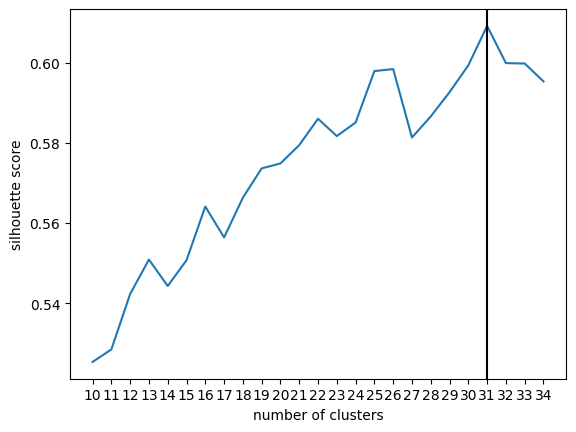

In [63]:
#  plot silhouette scores in line plot
import matplotlib.pyplot as plt
plt.plot(range_n_cluster, scores)
plt.axvline(best_cluster_model.n_clusters, color='black')

plt.xlabel('number of clusters')
plt.ylabel('silhouette score')

plt.xticks(range_n_cluster)
plt.show()

In [67]:
new_features_names = [f'skills_group_{cluster_label}' for cluster_label in best_cluster_model.labels_]

visualizing clusters

In [70]:
fig = px.scatter(tsne_df, x=0, y=1, color=new_features_names)

for i, txt in enumerate(tsne_df.index):
    fig.add_annotation(x=tsne_df.iloc[i,0], y=tsne_df.iloc[i,1], text=txt, showarrow=False)
fig.update_traces(marker=dict(size=12,
                            line=dict(width=2,
                                        color='DarkSlateGrey')),
                selector=dict(mode='markers'))

fig.update_layout( width=1000, height=1000)
fig.show()


### Creating new features

In [92]:
skills_clusters_list =tsne_df.index.to_series().groupby(new_features_names).apply(list)
skills_clusters_list

skills_group_0     [Apex, Java, H2, Oracle, Oracle Cloud Infrastr...
skills_group_1     [C#, F#, PowerShell, SQL, Cosmos DB, Microsoft...
skills_group_10    [BigQuery, Cloud Firestore, Firebase Realtime ...
skills_group_11                  [Couch DB, Couchbase, Chef, Puppet]
skills_group_12    [VBA, Visual Basic (.Net), Microsoft Access, V...
skills_group_13    [DuckDB, RavenDB, TiDB, Colocation, Lit, JAX, ...
skills_group_14    [Dart, Groovy, Kotlin, Flutter, Ktor, Dagger, ...
skills_group_15           [GDScript, Godot, Unity 3D, Unreal Engine]
skills_group_16    [Lua, Rust, Tauri, Cargo, Nix, Pacman, Helix, ...
skills_group_17    [PHP, MariaDB, MySQL, SQLite, Solr, Managed Ho...
skills_group_18    [Scala, Cassandra, Clickhouse, Snowflake, Play...
skills_group_19    [Delphi, Firebird, Rad Studio (Delphi, C++ Bui...
skills_group_2     [HTML/CSS, JavaScript, TypeScript, MongoDB, An...
skills_group_20                          [Capacitor, Cordova, Ionic]
skills_group_21    [Solidity, Supa

In [102]:
new_features = []

for cluster, skills in skills_clusters_list.items():
    cluster_sum = df.drop('DevType', axis=1).copy().droplevel(0, axis=1)[skills].sum(axis=1)
    cluster_sum.name = cluster
    new_features.append(cluster_sum)

clustered_skills_df = pd.concat(new_features, axis=1)

In [104]:
clustered_skills_df.sample(5)

,skills_group_0,skills_group_1,skills_group_10,skills_group_11,skills_group_12,skills_group_13,skills_group_14,skills_group_15,skills_group_16,skills_group_17,...,skills_group_28,skills_group_29,skills_group_3,skills_group_30,skills_group_4,skills_group_5,skills_group_6,skills_group_7,skills_group_8,skills_group_9
40105,0,11,1,0,2,0,1,1,0,4,...,0,1,0,0,0,0,2,0,0,0
61442,1,2,0,2,1,0,1,0,1,2,...,2,0,4,0,3,2,9,1,2,0
78753,0,3,1,0,1,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
35552,4,2,2,0,1,0,1,0,0,3,...,2,0,0,0,0,0,0,0,0,0
15526,2,7,0,0,1,0,0,1,3,4,...,1,0,2,1,1,0,2,1,0,0


In [105]:
# exporting clustered_skills_df as pickle file
clustered_skills_df.to_pickle(CLUSTER_SKILLS_DF_PATH)

# 2- Cleaning Respoonses& irrelevant Jobs

In [6]:
skills_df = pd.read_pickle(CLUSTER_SKILLS_DF_PATH)
jobs_df =  df.loc[:,['DevType']].copy().droplevel(0, axis=1)
skills_jobs_df = pd.concat([skills_df,jobs_df], axis=1)

In [7]:
display(
    skills_df.sample(1),
    jobs_df.sample(1),
    skills_jobs_df.sample(1)
)

,skills_group_0,skills_group_1,skills_group_10,skills_group_11,skills_group_12,skills_group_13,skills_group_14,skills_group_15,skills_group_16,skills_group_17,...,skills_group_28,skills_group_29,skills_group_3,skills_group_30,skills_group_4,skills_group_5,skills_group_6,skills_group_7,skills_group_8,skills_group_9
6662,4,0,1,0,0,0,0,0,3,1,...,1,1,0,0,0,0,5,0,0,0


,Blockchain,Cloud infrastructure engineer,Data or business analyst,Data scientist or machine learning specialist,Database administrator,DevOps specialist,Developer Advocate,Developer Experience,"Developer, QA or test","Developer, back-end",...,"Engineer, site reliability",Engineering manager,Hardware Engineer,Product manager,Project manager,Research & Development role,Scientist,Security professional,"Senior Executive (C-Suite, VP, etc.)",System administrator
16270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,skills_group_0,skills_group_1,skills_group_10,skills_group_11,skills_group_12,skills_group_13,skills_group_14,skills_group_15,skills_group_16,skills_group_17,...,"Engineer, site reliability",Engineering manager,Hardware Engineer,Product manager,Project manager,Research & Development role,Scientist,Security professional,"Senior Executive (C-Suite, VP, etc.)",System administrator
10784,0,0,1,0,0,1,0,0,1,2,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Exclude unrelevant roles

In [8]:
jobs_df = jobs_df.drop(columns=EXCLUDE_ROLES)
skills_jobs_df =skills_jobs_df.drop(columns = EXCLUDE_ROLES) 

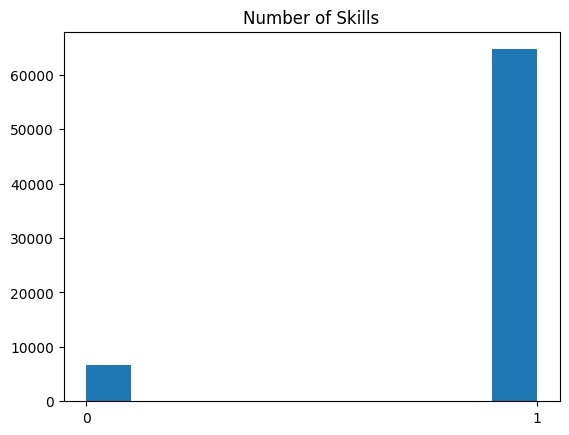

In [16]:
# historgram
freq_jobs = skills_jobs_df.loc[:,jobs_df.columns].sum(axis=1)
# plot histogram for freq_jobs
plt.hist(freq_jobs)
plt.title('Number of Skills')
# adjust the x-axis number
plt.xticks(list(set(freq_jobs.values)))
plt.show()

In [22]:
# drop responses with zero job 
skills_jobs_df = skills_jobs_df.drop(freq_jobs[freq_jobs==0].index)
skills_jobs_df.shape

(64659, 52)

In [25]:
# histogram for technical skills frequency
freq_skills = skills_jobs_df.loc[:,skills_df.columns].sum(axis=1)
# plot histogram for freq_skills with plotly and number of bins =100
fig = px.histogram(freq_skills, nbins=100)
fig.update_layout(title='Number of Skills')
fig.show()

In [28]:
SKILLS_RANGE= [2,40]
# droping record out of SKILLS_RANGE
skills_jobs_df = skills_jobs_df.drop(freq_skills[(freq_skills<SKILLS_RANGE[0]) | (freq_skills>SKILLS_RANGE[1])].index)
skills_jobs_df.shape

(59628, 52)

In [29]:
# histogram for technical skills frequency
freq_skills = skills_jobs_df.loc[:,skills_df.columns].sum(axis=1)
# plot histogram for freq_skills with plotly and number of bins =100
import plotly.express as px
fig = px.histogram(freq_skills, nbins=100)
fig.update_layout(title='Number of Skills')
fig.show()

# Export cleaned dataframe

In [31]:
skills_jobs_df.to_pickle(CLEANED_DF_PATH)